In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import lightgbm as lgb

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# Load data

In [3]:
hk1_X = pd.read_csv('hk1_X.csv')
hk1_y = pd.read_csv('hk1_y.csv', header=None)
hk1_y.columns = ['TARGET']
hk1_X.shape, hk1_y.shape
hk1_df = pd.concat([hk1_X, hk1_y], axis=1)
hk1_df.head()
hk1_y = hk1_y['TARGET']

hk2_X = pd.read_csv('hk2_X.csv')
hk2_y = pd.read_csv('hk2_y.csv', header=None)
hk2_y.columns = ['TARGET']
hk2_X.shape, hk2_y.shape
hk2_df = pd.concat([hk2_X, hk2_y], axis=1)
hk2_df.head()
hk2_y = hk2_y['TARGET']

((768, 43), (768, 1))

,Edad,ingresoef,pregunta_1,pregunta_2,pregunta_3,pregunta_4,pregunta_5,pregunta_6,pregunta_7,pregunta_8,...,D__ASESOR COMERCIAL JUNIOR 2,D__ASESOR COMERCIAL MASTER,D__ASESOR COMERCIAL SENIOR,D__Femenino,D__Masculino,D__Casado,D__Otros,D__Soltero,cluster,TARGET
0,36,0,0.210433,0.014503,0.580707,0.475461,0.191990,0.208157,0.007626,0.853459,...,0,0,0,0,1,0,0,1,-1,0
1,46,0,0.789044,0.343001,0.058207,0.926026,0.871500,0.939968,0.929000,0.118791,...,0,1,0,1,0,0,1,0,-1,2
2,58,0,0.242838,0.528969,0.716495,0.489488,0.286807,0.528751,0.501223,0.036598,...,0,1,0,1,0,1,0,0,-1,0
3,34,0,0.761830,0.494812,0.321391,0.524197,0.645303,0.035893,0.909352,0.005753,...,0,0,0,1,0,0,0,1,-1,2
4,36,0,0.945418,0.833204,0.601921,0.857995,0.926111,0.913815,0.609726,0.990892,...,0,0,0,1,0,0,0,1,-1,1


((768, 59), (768, 1))

,nEntidades_competencia,nDesem_ult_semana,cero_cuotas,nPorcentaje_cero_cuotas_ope,nPorcentaje_sal_cero_cuo,Amonestacion,nAmonestacion_suspension,nvarsaldocapital,herencia,nporcentaje_Herencia,...,D__ASESOR COMERCIAL SENIOR,D__Femenino,D__Masculino,D__Casado,D__Otros,D__Soltero,D__R,D__U,cluster,TARGET
0,1,0.256354,1,0.000000,0.000000,0,0,0.013561,1,0.380552,...,0,0,1,0,0,1,0,1,-1,0
1,0,0.406922,1,0.001969,0.000141,0,0,0.042866,1,0.444054,...,0,1,0,0,1,0,0,1,-1,2
2,5,0.321911,1,0.000000,0.000000,0,0,-0.005801,1,0.020612,...,0,1,0,1,0,0,0,1,-1,0
3,3,0.294114,1,0.008791,0.015452,0,0,0.018111,1,0.300313,...,0,1,0,0,0,1,0,1,0,2
4,2,0.315331,0,0.000000,0.000000,0,0,0.004865,1,0.151475,...,0,1,0,0,0,1,0,1,1,1


# Cross-validation

In [4]:
def cv(X, y, df):
    eval_size = 0.1
    kf = StratifiedKFold(df['TARGET'], round(1./eval_size))
    train_ix, valid_ix = next(iter(kf))
    X_train, y_train = X.iloc[train_ix], y.iloc[train_ix]
    X_valid, y_valid = X.iloc[valid_ix], y.iloc[valid_ix]
    return X_train, y_train, X_valid, y_valid

In [5]:
model_results = {
    'lightgbm': {
        'recall': None,
        'precision': None,
        'accuracy': None
    },
    'random_forest': {
        'recall': None,
        'precision': None,
        'accuracy': None
    },
    'extra_trees': {
        'recall': None,
        'precision': None,
        'accuracy': None
    }
}

In [6]:
def run_lgbm(X_train, y_train, X_valid, y_valid):
    d_train = lgb.Dataset(X_train, y_train)
    d_valid = lgb.Dataset(X_valid, y_valid, reference=d_train)
    params = {
         'boosting_type': 'gbdt',
         'colsample_bytree': 0.8,
         'is_unbalance': False,
         'learning_rate': 0.04,
         'metric': 'multi_logloss',
         'num_class': 3,
         'num_leaves': 30,
         'objective': 'multiclass',
         'reg_alpha': 1,
         'reg_lambda': 6,
         'subsample': 0.9,
         'verbose': 0
    }
    model = lgb.train(params, d_train, 100, valid_sets=d_valid, verbose_eval=False)

    y_pred = model.predict(X_valid)

    y_pred_trunc = list()
    for row in y_pred:
        y_pred_trunc.append(list(row).index(max(row)))
    y_pred_trunc = pd.Series(y_pred_trunc)

    cm = confusion_matrix(y_valid, y_pred_trunc)
    
    recall = cm[2][2]/sum(cm[2])
    model_results['lightgbm']['recall'] = recall

    precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
    model_results['lightgbm']['precision'] = precision

    accuracy = accuracy_score(y_pred_trunc, y_valid)
    model_results['lightgbm']['accuracy'] = accuracy

In [7]:
def run_rfe(X_train, y_train, X_valid, y_valid):
    model = RandomForestClassifier(
        max_depth=5,
        min_samples_leaf=5,
        min_samples_split=100,
        n_estimators=120)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)

    cm = confusion_matrix(y_valid, y_pred)
    
    recall = cm[2][2]/sum(cm[2])
    model_results['random_forest']['recall'] = recall

    precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
    model_results['random_forest']['precision'] = precision

    accuracy = accuracy_score(y_pred, y_valid)
    model_results['random_forest']['accuracy'] = accuracy

In [8]:
def run_et(X_train, y_train, X_valid, y_valid):
    model = ExtraTreesClassifier(
        min_samples_leaf=10,
        min_samples_split=2,
        n_estimators=1200)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    cm = confusion_matrix(y_valid, y_pred)
    
    recall = cm[2][2]/sum(cm[2])
    model_results['extra_trees']['recall'] = recall

    precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
    model_results['extra_trees']['precision'] = precision

    accuracy = accuracy_score(y_pred, y_valid)
    model_results['extra_trees']['accuracy'] = accuracy

# HK1 Benchmark

,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.384615,0.406250,0.838710
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.384615,0.806452
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.393939,0.838710
2,extra_trees,0.358974,0.375000,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.410256,0.419355,0.838710
2,extra_trees,0.397436,0.396825,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.397436,0.415385,0.870968
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.346154,0.369231,0.774194
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.393939,0.838710
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.384615,0.402985,0.870968
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.384615,0.400000,0.838710
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.397436,0.402985,0.870968
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.400000,0.903226
2,extra_trees,0.384615,0.384615,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.346154,0.382353,0.838710
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.346154,0.382353,0.838710
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.397436,0.422535,0.967742
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.320513,0.365079,0.741935
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.410256,0.428571,0.870968
2,extra_trees,0.397436,0.396825,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.378788,0.806452
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.382353,0.838710
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.393939,0.838710
2,extra_trees,0.358974,0.378788,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.378788,0.806452
2,extra_trees,0.371795,0.384615,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.384615,0.394366,0.903226
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.384615,0.391304,0.870968
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.393939,0.838710
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.393939,0.838710
2,extra_trees,0.410256,0.409836,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.333333,0.362319,0.806452
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.403226,0.806452
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.397059,0.870968
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.397436,0.412698,0.838710
2,extra_trees,0.397436,0.396825,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.382353,0.838710
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.333333,0.382353,0.838710
2,extra_trees,0.371795,0.380952,0.774194


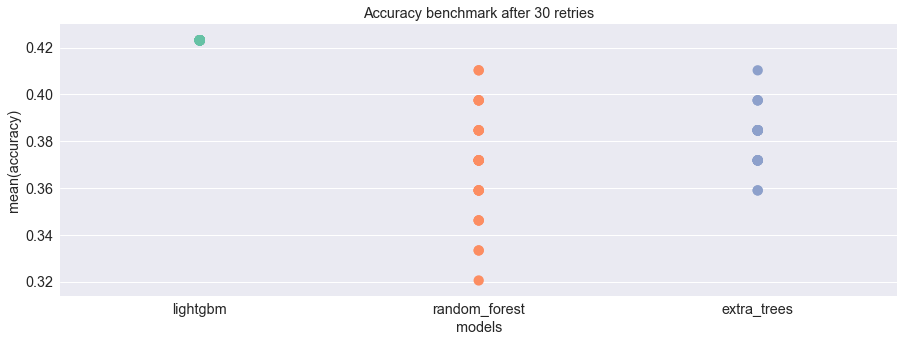

In [9]:
for i in range(30):
    hk1_X_train, hk1_y_train, hk1_X_valid, hk1_y_valid = cv(hk1_X, hk1_y, hk1_df)
    run_lgbm(hk1_X_train, hk1_y_train, hk1_X_valid, hk1_y_valid)
    run_rfe(hk1_X_train, hk1_y_train, hk1_X_valid, hk1_y_valid)
    run_et(hk1_X_train, hk1_y_train, hk1_X_valid, hk1_y_valid)
    s1 = pd.Series(model_results['lightgbm'], name='lightgbm')[['accuracy', 'precision', 'recall']]
    s2 = pd.Series(model_results['random_forest'], name='random_forest')[['accuracy', 'precision', 'recall']]
    s3 = pd.Series(model_results['extra_trees'], name='extra_trees')[['accuracy', 'precision', 'recall']]
    dff = pd.concat([s1, s2, s3], axis=1).T
    dff = dff.reset_index()
    dff
    g = sns.pointplot(x="index", y="accuracy", data=dff.reset_index(), palette="Set2")
    g.set_title('Accuracy benchmark after 30 retries')
    g.set_xlabel('models')

,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.400000,0.838710
2,extra_trees,0.397436,0.396825,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.382353,0.838710
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.385714,0.870968
2,extra_trees,0.397436,0.396825,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.410256,0.421875,0.870968
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.389831,0.741935
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.384615,0.405797,0.903226
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.346154,0.369231,0.774194
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.390625,0.806452
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.409091,0.870968
2,extra_trees,0.397436,0.396825,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.400000,0.903226
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.384615,0.426230,0.838710
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.387097,0.774194
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.385714,0.870968
2,extra_trees,0.384615,0.387097,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.391892,0.935484
2,extra_trees,0.371795,0.377049,0.741935


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.384615,0.405797,0.903226
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.384615,0.397059,0.870968
2,extra_trees,0.371795,0.384615,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.410256,0.432836,0.935484
2,extra_trees,0.397436,0.396825,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.376812,0.838710
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.435897,0.419355,0.838710
2,extra_trees,0.397436,0.396825,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.384615,0.403226,0.806452
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.384615,0.412698,0.838710
2,extra_trees,0.397436,0.396825,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.397436,0.424242,0.903226
2,extra_trees,0.384615,0.387097,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.397059,0.870968
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.397436,0.411765,0.903226
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.346154,0.378788,0.806452
2,extra_trees,0.410256,0.403226,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.397436,0.421875,0.870968
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.307692,0.359375,0.741935
2,extra_trees,0.397436,0.396825,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.384615,0.421875,0.870968
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.346154,0.375000,0.774194
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.384615,0.402985,0.870968
2,extra_trees,0.384615,0.387097,0.774194


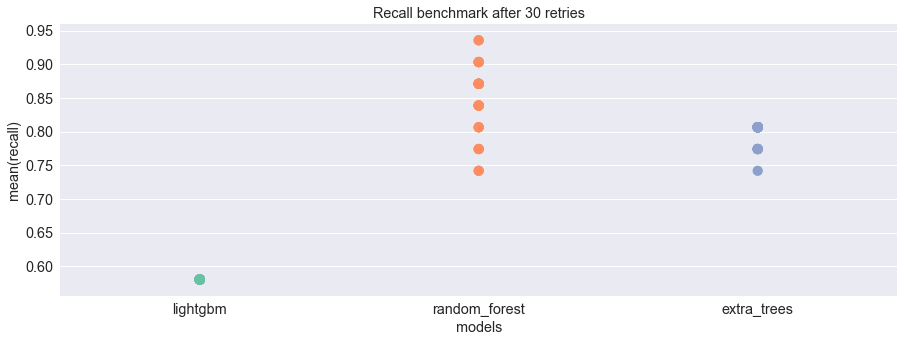

In [10]:
for i in range(30):
    hk1_X_train, hk1_y_train, hk1_X_valid, hk1_y_valid = cv(hk1_X, hk1_y, hk1_df)
    run_lgbm(hk1_X_train, hk1_y_train, hk1_X_valid, hk1_y_valid)
    run_rfe(hk1_X_train, hk1_y_train, hk1_X_valid, hk1_y_valid)
    run_et(hk1_X_train, hk1_y_train, hk1_X_valid, hk1_y_valid)
    s1 = pd.Series(model_results['lightgbm'], name='lightgbm')[['accuracy', 'precision', 'recall']]
    s2 = pd.Series(model_results['random_forest'], name='random_forest')[['accuracy', 'precision', 'recall']]
    s3 = pd.Series(model_results['extra_trees'], name='extra_trees')[['accuracy', 'precision', 'recall']]
    dff = pd.concat([s1, s2, s3], axis=1).T
    dff = dff.reset_index()
    dff  
    g = sns.pointplot(x="index", y="recall", data=dff, palette="Set2")
    g.set_title('Recall benchmark after 30 retries')
    g.set_xlabel('models')

,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.382353,0.838710
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.393443,0.774194
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.389831,0.741935
2,extra_trees,0.358974,0.375000,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.384615,0.402985,0.870968
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.384615,0.405797,0.903226
2,extra_trees,0.397436,0.396825,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.307692,0.354839,0.709677
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.403226,0.806452
2,extra_trees,0.384615,0.387097,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.384615,0.397260,0.935484
2,extra_trees,0.397436,0.396825,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.333333,0.370968,0.741935
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.397059,0.870968
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.346154,0.391304,0.870968
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.382353,0.838710
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.385714,0.870968
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.382353,0.838710
2,extra_trees,0.358974,0.375000,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.384615,0.400000,0.838710
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.390625,0.806452
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.333333,0.365079,0.741935
2,extra_trees,0.397436,0.396825,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.397436,0.419355,0.838710
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.378788,0.806452
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.388889,0.903226
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.346154,0.378788,0.806452
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.382353,0.838710
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.346154,0.376812,0.838710
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.346154,0.359375,0.741935
2,extra_trees,0.358974,0.375000,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.320513,0.360656,0.709677
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.402985,0.870968
2,extra_trees,0.358974,0.375000,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.371795,0.391304,0.870968
2,extra_trees,0.384615,0.390625,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.388060,0.838710
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.391304,0.870968
2,extra_trees,0.371795,0.380952,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.423077,0.529412,0.580645
1,random_forest,0.358974,0.384615,0.806452
2,extra_trees,0.384615,0.390625,0.806452


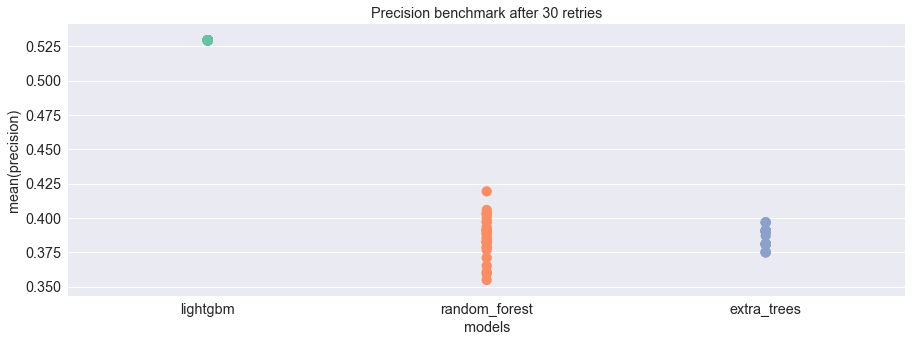

In [13]:
for i in range(30):
    hk1_X_train, hk1_y_train, hk1_X_valid, hk1_y_valid = cv(hk1_X, hk1_y, hk1_df)
    run_lgbm(hk1_X_train, hk1_y_train, hk1_X_valid, hk1_y_valid)
    run_rfe(hk1_X_train, hk1_y_train, hk1_X_valid, hk1_y_valid)
    run_et(hk1_X_train, hk1_y_train, hk1_X_valid, hk1_y_valid)
    s1 = pd.Series(model_results['lightgbm'], name='lightgbm')[['accuracy', 'precision', 'recall']]
    s2 = pd.Series(model_results['random_forest'], name='random_forest')[['accuracy', 'precision', 'recall']]
    s3 = pd.Series(model_results['extra_trees'], name='extra_trees')[['accuracy', 'precision', 'recall']]
    dff = pd.concat([s1, s2, s3], axis=1).T
    dff = dff.reset_index()
    dff  
    g = sns.pointplot(x="index", y="precision", data=dff, palette="Set2")
    g.set_title('Precision benchmark after 30 retries')
    g.set_xlabel('models')

# HK2 Benchmark

,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.500000,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.512821,0.510204,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.480769,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.461538,0.461538,0.774194
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.474359,0.470588,0.774194
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.474359,0.480000,0.774194
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.525641,0.500000,0.838710
2,extra_trees,0.487179,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.481481,0.838710
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.525641,0.510204,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.489362,0.741935
2,extra_trees,0.474359,0.470588,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.448718,0.458333,0.709677
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.474359,0.460000,0.741935
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.474359,0.470588,0.774194
2,extra_trees,0.500000,0.480769,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.458333,0.709677
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.480000,0.774194
2,extra_trees,0.487179,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.474359,0.469388,0.741935
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.490196,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.490196,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.500000,0.774194
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.512821,0.500000,0.870968
2,extra_trees,0.487179,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.489796,0.774194
2,extra_trees,0.487179,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.482143,0.870968
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.489796,0.774194
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.471698,0.806452
2,extra_trees,0.487179,0.480000,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.490196,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.448718,0.460000,0.741935
2,extra_trees,0.500000,0.480769,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.489796,0.774194
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.474359,0.462963,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.538462,0.520833,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.489796,0.774194
2,extra_trees,0.500000,0.490196,0.806452


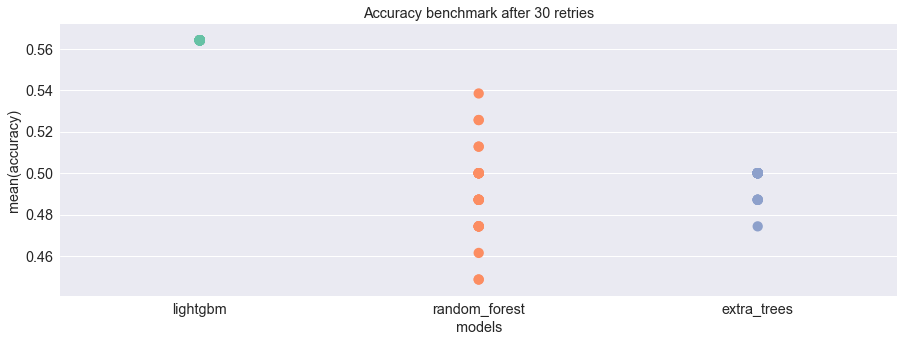

In [14]:
for i in range(30):
    hk2_X_train, hk2_y_train, hk2_X_valid, hk2_y_valid = cv(hk2_X, hk2_y, hk2_df)
    run_lgbm(hk2_X_train, hk2_y_train, hk2_X_valid, hk2_y_valid)
    run_rfe(hk2_X_train, hk2_y_train, hk2_X_valid, hk2_y_valid)
    run_et(hk2_X_train, hk2_y_train, hk2_X_valid, hk2_y_valid)
    s1 = pd.Series(model_results['lightgbm'], name='lightgbm')[['accuracy', 'precision', 'recall']]
    s2 = pd.Series(model_results['random_forest'], name='random_forest')[['accuracy', 'precision', 'recall']]
    s3 = pd.Series(model_results['extra_trees'], name='extra_trees')[['accuracy', 'precision', 'recall']]
    dff = pd.concat([s1, s2, s3], axis=1).T
    dff = dff.reset_index()
    dff
    g = sns.pointplot(x="index", y="accuracy", data=dff.reset_index(), palette="Set2")
    g.set_title('Accuracy benchmark after 30 retries')
    g.set_xlabel('models')

,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.489796,0.774194
2,extra_trees,0.500000,0.480769,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.480769,0.806452
2,extra_trees,0.512821,0.500000,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.489796,0.774194
2,extra_trees,0.487179,0.480769,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.448718,0.466667,0.677419
2,extra_trees,0.487179,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.474359,0.442308,0.741935
2,extra_trees,0.512821,0.500000,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.474359,0.466667,0.677419
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.511111,0.741935
2,extra_trees,0.500000,0.480769,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.489362,0.741935
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.512821,0.510204,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.512821,0.500000,0.774194
2,extra_trees,0.500000,0.480769,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.474359,0.468085,0.709677
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.512821,0.490566,0.838710
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.474359,0.471698,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.489362,0.741935
2,extra_trees,0.487179,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.512821,0.509804,0.838710
2,extra_trees,0.500000,0.480769,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.512821,0.490196,0.806452
2,extra_trees,0.500000,0.500000,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.490566,0.838710
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.490196,0.806452
2,extra_trees,0.512821,0.500000,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.490566,0.838710
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.489796,0.774194
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.474359,0.469388,0.741935
2,extra_trees,0.500000,0.480769,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.461538,0.460000,0.741935
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.474359,0.470588,0.774194
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.512821,0.509804,0.838710
2,extra_trees,0.487179,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.480769,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.525641,0.510204,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.480000,0.774194
2,extra_trees,0.500000,0.500000,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.490196,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.470588,0.774194
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.480000,0.774194
2,extra_trees,0.500000,0.490196,0.806452


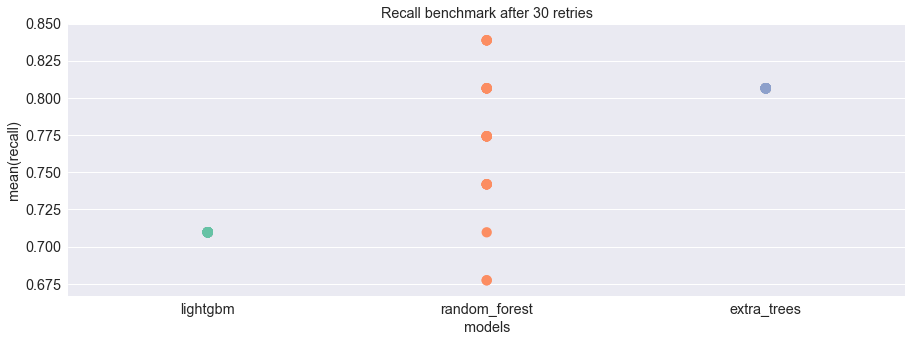

In [15]:
for i in range(30):
    hk2_X_train, hk2_y_train, hk2_X_valid, hk2_y_valid = cv(hk2_X, hk2_y, hk2_df)
    run_lgbm(hk2_X_train, hk2_y_train, hk2_X_valid, hk2_y_valid)
    run_rfe(hk2_X_train, hk2_y_train, hk2_X_valid, hk2_y_valid)
    run_et(hk2_X_train, hk2_y_train, hk2_X_valid, hk2_y_valid)
    s1 = pd.Series(model_results['lightgbm'], name='lightgbm')[['accuracy', 'precision', 'recall']]
    s2 = pd.Series(model_results['random_forest'], name='random_forest')[['accuracy', 'precision', 'recall']]
    s3 = pd.Series(model_results['extra_trees'], name='extra_trees')[['accuracy', 'precision', 'recall']]
    dff = pd.concat([s1, s2, s3], axis=1).T
    dff = dff.reset_index()
    dff  
    g = sns.pointplot(x="index", y="recall", data=dff, palette="Set2")
    g.set_title('Recall benchmark after 30 retries')
    g.set_xlabel('models')

,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.489796,0.774194
2,extra_trees,0.500000,0.500000,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.500000,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.489796,0.774194
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.474359,0.479167,0.741935
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.500000,0.709677
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.509804,0.838710
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.471698,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.474359,0.489362,0.741935
2,extra_trees,0.474359,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.500000,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.474359,0.480000,0.774194
2,extra_trees,0.487179,0.480000,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.471698,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.480000,0.774194
2,extra_trees,0.500000,0.480769,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.510204,0.806452
2,extra_trees,0.487179,0.480000,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.479167,0.741935
2,extra_trees,0.500000,0.480769,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.461538,0.452830,0.774194
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.472727,0.838710
2,extra_trees,0.487179,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.525641,0.521739,0.774194
2,extra_trees,0.512821,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.461538,0.460000,0.741935
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.487179,0.488889,0.709677
2,extra_trees,0.500000,0.500000,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.525641,0.500000,0.838710
2,extra_trees,0.500000,0.480769,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.512821,0.510204,0.806452
2,extra_trees,0.487179,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.474359,0.452830,0.774194
2,extra_trees,0.487179,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.525641,0.509434,0.870968
2,extra_trees,0.500000,0.480000,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.461538,0.469388,0.741935
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.512821,0.500000,0.838710
2,extra_trees,0.500000,0.480769,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.512821,0.510204,0.806452
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.509804,0.838710
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.500000,0.500000,0.741935
2,extra_trees,0.500000,0.490196,0.806452


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.474359,0.470588,0.774194
2,extra_trees,0.487179,0.480000,0.774194


,index,accuracy,precision,recall
0,lightgbm,0.564103,0.611111,0.709677
1,random_forest,0.525641,0.500000,0.838710
2,extra_trees,0.500000,0.490196,0.806452


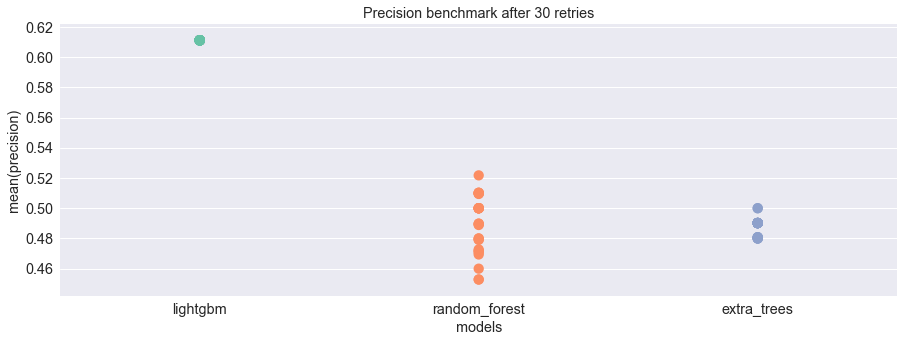

In [17]:
for i in range(30):
    hk2_X_train, hk2_y_train, hk2_X_valid, hk2_y_valid = cv(hk2_X, hk2_y, hk2_df)
    run_lgbm(hk2_X_train, hk2_y_train, hk2_X_valid, hk2_y_valid)
    run_rfe(hk2_X_train, hk2_y_train, hk2_X_valid, hk2_y_valid)
    run_et(hk2_X_train, hk2_y_train, hk2_X_valid, hk2_y_valid)
    s1 = pd.Series(model_results['lightgbm'], name='lightgbm')[['accuracy', 'precision', 'recall']]
    s2 = pd.Series(model_results['random_forest'], name='random_forest')[['accuracy', 'precision', 'recall']]
    s3 = pd.Series(model_results['extra_trees'], name='extra_trees')[['accuracy', 'precision', 'recall']]
    dff = pd.concat([s1, s2, s3], axis=1).T
    dff = dff.reset_index()
    dff  
    g = sns.pointplot(x="index", y="precision", data=dff, palette="Set2")
    g.set_title('Precision benchmark after 30 retries')
    g.set_xlabel('models')